In [6]:
pip install pandas numpy


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
pip install openpyxl



  Obtaining dependency information for openpyxl from https://files.pythonhosted.org/packages/c0/da/977ded879c29cbd04de313843e76868e6e13408a94ed6b987245dc7c8506/openpyxl-3.1.5-py2.py3-none-any.whl.metadata
  Obtaining dependency information for et-xmlfile from https://files.pythonhosted.org/packages/96/c2/3dd434b0108730014f1b96fd286040dc3bcb70066346f7e01ec2ac95865f/et_xmlfile-1.1.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/250.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/250.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/250.9 kB 435.7 kB/s eta 0:00:01
   ------------ -------------------------- 81.9/250.9 kB 651.6 kB/s eta 0:00:01
   ------------------------ ------------- 163.8/250.9 kB 978.3 kB/s eta 0:00:01
   ---------------------------------------  245.8/250.9 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 250.9/250.9 kB 1.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
#importacion de pandas
import pandas as pd

#primero leer los datos, definiciones

# archivo de clientes:  Datos de identificación de los clientes y la ubicación del domicilio que tienen registrado con Olist para recibir pedidos.
customers_df = pd.read_excel(r'C:\Users\admin\Desktop\NAO\Fuente de Datos\olist_customers_dataset.xlsx')

# Archivo de Ordenes: Datos de identificación de las órdenes realizadas por los clientes, su estatus de envío y la cronología de entrega en el domicilio del cliente
orders_df = pd.read_csv(r'C:\Users\admin\Desktop\NAO\Fuente de Datos\olist_orders_dataset.csv')

# Archivo de geolocalización: Datos de geolocalización de códigos postales de zonas de Brasil.
geolocation_df = pd.read_csv(r'C:\Users\admin\Desktop\NAO\Fuente de Datos\olist_geolocation_dataset.csv')

#archivo de artículos de órdenes: Contiene la relación de artículos contenidos en las órdenes de los clientes 
order_items_df = pd.read_csv(r'C:\Users\admin\Desktop\NAO\Fuente de Datos\olist_order_items_dataset.csv')

# archivo de pagos: Contiene la relación de pagos que cada cliente hizo en sus órdenes por medio de pago
payments_df = pd.read_csv(r'C:\Users\admin\Desktop\NAO\Fuente de Datos\olist_order_payments_dataset.csv')



# archivo de abreviaciones de estados: Contiene la relación de nombres de los estados de Brasil y sus abreviaciones. 
states_df = pd.read_json(r'C:\Users\admin\Desktop\NAO\Fuente de Datos\states_abbreviations.json')


#============================================================================================================================
#============================================================================================================================

#Paso dos: Consolidar en base al diagrama

df = pd.merge(orders_df, customers_df, on='customer_id', how='left')
df = pd.merge(df, geolocation_df, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
df = pd.merge(df, states_df, left_on='geolocation_state', right_on='state_name', how='left')
df = pd.merge(df, order_items_df, on='order_id', how='left')
df = pd.merge(df, payments_df, on='order_id', how='left')


#============================================================================================================================
#============================================================================================================================


# Paso 3: Agregar campos calculados

# Total de productos de la orden
df['total_products'] = df.groupby('order_id')['order_item_id'].transform('count')

# Total monetario de la orden
df['total_sales'] = df.groupby('order_id')['payment_value'].transform('sum')

# Año, mes, trimestre, y año-mes de la compra
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['year'] = df['order_purchase_timestamp'].dt.year
df['month'] = df['order_purchase_timestamp'].dt.month
df['quarter'] = df['order_purchase_timestamp'].dt.quarter
df['year_month'] = df['order_purchase_timestamp'].dt.to_period('M').astype(str)

# Días transcurridos entre la fecha estimada de entrega y la entrega efectiva
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['delta_days'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days

# Estado de retraso
df['delay_status'] = df['delta_days'].apply(lambda x: 'no_delay' if pd.isna(x) or x <= 0 else ('short_delay' if x <= 3 else 'long_delay'))


#============================================================================================================================
#============================================================================================================================

# Paso 4: Guardar el DataFrame consolidado en un archivo CSV
df.to_csv(r'C:\Users\admin\Desktop\NAO\Tabla consolidada\oilst_processed.csv', index=False)

print("El archivo olist_processed.csv ha sido creado exitosamente.")

El archivo olist_processed.csv ha sido creado exitosamente.


In [25]:
#todo junto sin el detalle de desarrollo 


import pandas as pd
import numpy as np
from datetime import datetime

# Leer las fuentes de datos
customers_df     = pd.read_excel(r'C:\Users\admin\Desktop\NAO\Fuente de Datos\olist_customers_dataset.xlsx')
orders_df        = pd.read_csv(r'C:\Users\admin\Desktop\NAO\Fuente de Datos\olist_orders_dataset.csv')
geolocation_df   = pd.read_csv(r'C:\Users\admin\Desktop\NAO\Fuente de Datos\olist_geolocation_dataset.csv')
order_items_df   = pd.read_csv(r'C:\Users\admin\Desktop\NAO\Fuente de Datos\olist_order_items_dataset.csv')
payments_df      = pd.read_csv(r'C:\Users\admin\Desktop\NAO\Fuente de Datos\olist_order_payments_dataset.csv')
states_df        = pd.read_json(r'C:\Users\admin\Desktop\NAO\Fuente de Datos\states_abbreviations.json')

# Consolidar los datos
df = pd.merge(orders_df, customers_df, on='customer_id', how='left')
df = pd.merge(df, geolocation_df, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
df = pd.merge(df, states_df, left_on='geolocation_state', right_on='state_name', how='left')
df = pd.merge(df, order_items_df, on='order_id', how='left')
df = pd.merge(df, payments_df, on='order_id', how='left')

# Campos calculados
df['total_products']                = df.groupby('order_id')['order_item_id'].transform('count')
df['total_sales']                   = df.groupby('order_id')['payment_value'].transform('sum')
df['order_purchase_timestamp']      = pd.to_datetime(df['order_purchase_timestamp'])
df['year']                          = df['order_purchase_timestamp'].dt.year
df['month']                         = df['order_purchase_timestamp'].dt.month
df['quarter']                       = df['order_purchase_timestamp'].dt.quarter
df['year_month']                    = df['order_purchase_timestamp'].dt.to_period('M').astype(str)
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['delta_days']                    = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days
df['delay_status']                  = df['delta_days'].apply(lambda x: 'no_delay' if pd.isna(x) or x <= 0 else ('short_delay' if x <= 3 else 'long_delay'))

# Guardar el DataFrame consolidado en un archivo CSV
output_path = r'C:\Users\admin\Desktop\NAO\Tabla consolidada\oilst_processed.csv'
df.to_csv(output_path, index=False)

print(f"El archivo {output_path} ha sido creado exitosamente.")


El archivo C:\Users\admin\Desktop\NAO\Tabla consolidada\oilst_processed.csv ha sido creado exitosamente.


In [26]:
import pandas as pd

# Definir la ruta del archivo CSV grande
input_path = r'C:\Users\admin\Desktop\NAO\Tabla consolidada\oilst_processed.csv'
output_folder = r'C:\Users\admin\Desktop\NAO\Tabla consolidada'

# Leer el archivo CSV en bloques y guardarlos en archivos más pequeños
chunk_size = 10**6  # Ajusta el tamaño del bloque según sea necesario
for i, chunk in enumerate(pd.read_csv(input_path, chunksize=chunk_size)):
    chunk.to_csv(f'{output_folder}\\oilst_processed_part_{i}.csv', index=False)

print("El archivo ha sido dividido en partes más pequeñas exitosamente.")


El archivo ha sido dividido en partes más pequeñas exitosamente.


In [1]:
# calcule la proporción que han representado las ventas de órdenes completas de Oilst dentro de los 
# categorías de delay_status y a los largo de los trimestres de 2016 a 2018.

#============================================================================================================================
#============================================================================================================================

import pandas as pd

input_folder = r'C:\Users\admin\Desktop\NAO\Tabla consolidada'
results_df = pd.DataFrame()

# Iterar sobre los archivos divididos
for i in range(19):  
    file_path = f'{input_folder}\\oilst_processed_part_{i}.csv'
    df = pd.read_csv(file_path)
    df = df[df['order_status'] == 'delivered']
    
    grouped = df.groupby(['year', 'quarter', 'delay_status']).agg({'total_sales': 'sum'}).reset_index()
    
    # proporción de ventas
    total_sales_by_quarter = grouped.groupby(['year', 'quarter'])['total_sales'].transform('sum')
    grouped['proportion'] = grouped['total_sales'] / total_sales_by_quarter
    
    # resultados
    results_df = pd.concat([results_df, grouped], ignore_index=True)

output_path = r'C:\Users\admin\Desktop\NAO\Resultados\prop_sales_delay_status_by_quarte.csv'
results_df.to_csv(output_path, index=False)

print(f"El archivo {output_path} ha sido creado exitosamente.")


El archivo C:\Users\admin\Desktop\NAO\Resultados\prop_sales_delay_status_by_quarte.csv ha sido creado exitosamente.


In [2]:

#número de órdenes que existieron por cantidad de productos dentro de la orden y el tipo de retraso de las categorías delay_status

#============================================================================================================================
#============================================================================================================================


import pandas as pd

input_folder = r'C:\Users\admin\Desktop\NAO\Tabla consolidada'
results_df = pd.DataFrame()

for i in range(19): 
    file_path = f'{input_folder}\\oilst_processed_part_{i}.csv'
    df = pd.read_csv(file_path)
    df = df[df['order_status'] == 'delivered']
    
    # Agrupados por cantidad de productos y estado de retraso
    grouped = df.groupby(['total_products', 'delay_status']).size().reset_index(name='order_count')
    
    # resultados
    results_df = pd.concat([results_df, grouped], ignore_index=True)

# Guardar el resultado
output_path = r'C:\Users\admin\Desktop\NAO\Resultados\count_orders_basket_size_by_delay_status.csv'
results_df.to_csv(output_path, index=False)

print(f"El archivo {output_path} ha sido creado exitosamente.")


El archivo C:\Users\admin\Desktop\NAO\Resultados\count_orders_basket_size_by_delay_status.csv ha sido creado exitosamente.


In [4]:
pip install matplotlib


  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/8b/ce/15b0bb2fb29b3d46211d8ca740b96b5232499fc49200b58b8d571292c9a6/matplotlib-3.9.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/d6/4f/76d0dd0bca417691918484c26c74dd9dd44fbf528bbfeb30d754886e2c54/contourpy-1.2.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/c8/e1/059700c154bd7170d1c37061239836d2e51ff608f47075450f06dd3c292a/fonttools-4.53.1-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/165.9 kB ? eta -:--:--
     ------ ------------------------------ 30.7/165.9 kB 640.0 kB/s e

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


El archivo C:\Users\admin\Desktop\NAO\Resultados\histogram_sales_long_delay.png ha sido creado exitosamente.


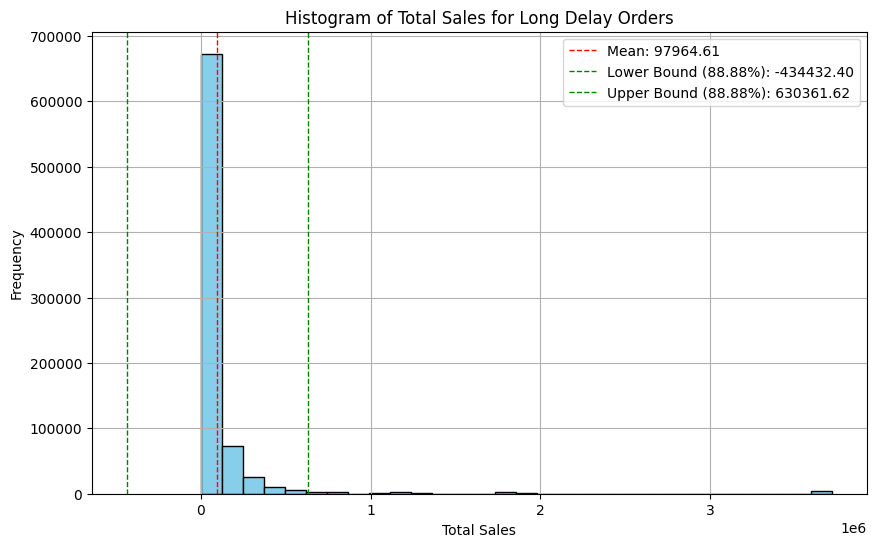

In [5]:
# Histograma

#============================================================================================================================
#============================================================================================================================


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

input_folder = r'C:\Users\admin\Desktop\NAO\Tabla consolidada'

# lista para acumular las ventas totales de retrasos largos
long_delay_sales = []

for i in range(19): 
    file_path = f'{input_folder}\\oilst_processed_part_{i}.csv'
    df = pd.read_csv(file_path)
    
    # Filtrar las órdenes con retraso largo y estado 'delivered'
    df = df[(df['delay_status'] == 'long_delay') & (df['order_status'] == 'delivered')]
    
   #ventas totales
    long_delay_sales.extend(df['total_sales'])

# De un array de numpy para el análisis
long_delay_sales = np.array(long_delay_sales)

# Calcular las estadísticas básicas
mean_sales = np.mean(long_delay_sales)
std_sales = np.std(long_delay_sales)

# Definir los intervalos 
lower_bound = mean_sales - 1.76 * std_sales
upper_bound = mean_sales + 1.76 * std_sales

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(long_delay_sales, bins=30, color='skyblue', edgecolor='black')
plt.axvline(mean_sales, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_sales:.2f}')
plt.axvline(lower_bound, color='green', linestyle='dashed', linewidth=1, label=f'Lower Bound (88.88%): {lower_bound:.2f}')
plt.axvline(upper_bound, color='green', linestyle='dashed', linewidth=1, label=f'Upper Bound (88.88%): {upper_bound:.2f}')
plt.title('Histogram of Total Sales for Long Delay Orders')
plt.xlabel('Total Sales')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)


output_path = r'C:\Users\admin\Desktop\NAO\Resultados\histogram_sales_long_delay.png'
plt.savefig(output_path)

print(f"El archivo {output_path} ha sido creado exitosamente.")


In [7]:
pip install pandas numpy seaborn matplotlib



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/294.9 kB 435.7 kB/s eta 0:00:01
   ------------ -------------------------- 92.2/294.9 kB 655.4 kB/s eta 0:00:01
   ---------------------- --------------- 174.1/294.9 kB 952.6 kB/s eta 0:00:01
   -------------------------------------- - 286.7/294.9 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 1.3 MB/s eta 0:00:00


El archivo C:\Users\admin\Desktop\NAO\Resultados\correlation_matrix_10_days_delay.png ha sido creado exitosamente.


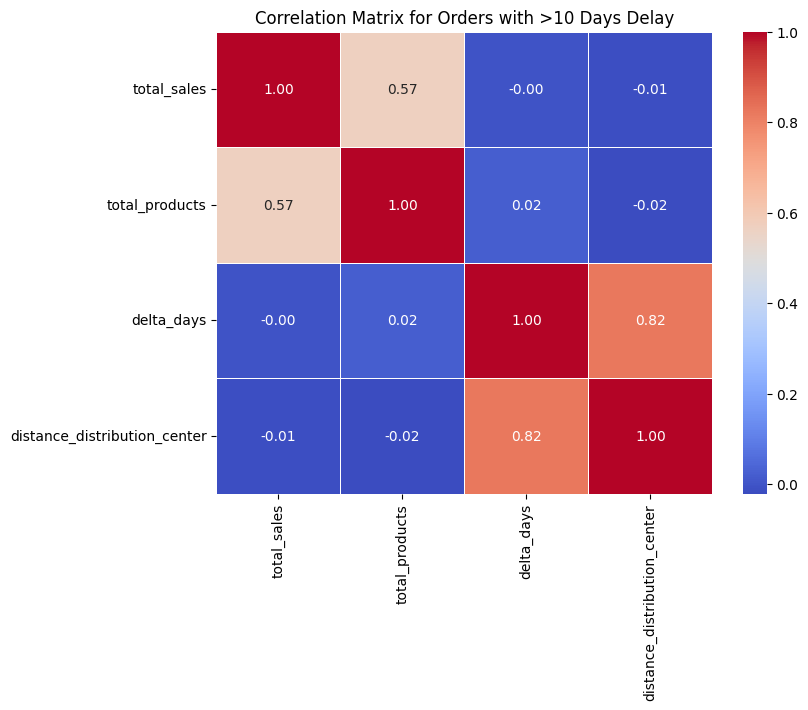

In [8]:
#calcule la matriz de correlación entre las variables total_sales, total_products, delta_days
#  y distance_distribution_center para órdenes completadas que cuya fecha de entrega sobrepasa los 10 días de la fecha estimada para la entrega.

#============================================================================================================================
#============================================================================================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

input_folder = r'C:\Users\admin\Desktop\NAO\Tabla consolidada'

df_combined = pd.DataFrame()


for i in range(19): 
    file_path = f'{input_folder}\\oilst_processed_part_{i}.csv'
    df = pd.read_csv(file_path)
    
    # Filtrar las órdenes completadas con un retraso mayor a 10 días
    df_filtered = df[(df['order_status'] == 'delivered') & (df['delta_days'] > 10)]
    
    #columnas que se necesitan
    df_filtered = df_filtered[['total_sales', 'total_products', 'delta_days', 'distance_distribution_center']]
    
    # Acumular los datos filtrados
    df_combined = pd.concat([df_combined, df_filtered])

# matriz de correlación
correlation_matrix = df_combined.corr()

#visualización de la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix for Orders with >10 Days Delay')


output_path = r'C:\Users\admin\Desktop\NAO\Resultados\correlation_matrix_10_days_delay.png'
plt.savefig(output_path)

print(f"El archivo {output_path} ha sido creado exitosamente.")

